# Problem 4

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

In [1]:
IMG_LEN = 28
IMG_SIZE = IMG_LEN**2

In [2]:
class QuadraticLoss(object):
    @staticmethod
    def loss(a, y):
        return 0.5*np.dot(a-y, a-y)
    @staticmethod
    def loss_derivative(a, y):
        return a-y
    

In [3]:
class CrossEntropyLoss(object):
    @staticmethod
    def loss(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    @staticmethod
    def loss_derivative(a, y):
        return (a-y)/(a*(1.0-a))

In [6]:
class Network(object):
    def __init__(self, n, *, loss=QuadraticLoss, init='standard'):
        # Initialize the weights randomly
        if init == 'standard':
            self.W = np.random.randn(n, IMG_SIZE)
            self.V = np.random.randn(10, n)
        elif init == 'normalized':
            self.W = np.random.randn(n, IMG_SIZE) / np.sqrt(IMG_SIZE)
            self.V = np.random.randn(10, n) / np.sqrt(n)
        
        self.b = np.random.randn(n)
        self.bprime = np.random.randn(10)
        self.loss = loss
        
    def feedforward(self, x):
        # Return the output of a feedforward pass
        a = sigmoid(np.dot(self.W, x)+self.b)
        return sigmoid(np.dot(self.V, a)+self.bprime)
    
    def evaluate(self, data, *, lmbda=0):
        """ Return (cost, accuracy) on the data"""
        correct_samples = 0
        total_cost = 0
        n_samples = len(data)
        
        for x, ylabel in data:
            y = self.feedforward(x)
            prediction = np.argmax(y)
            if prediction == ylabel:
                correct_samples += 1
            
            total_cost += self.loss.loss(y, Network.vec_output[ylabel])
        
        average_cost = total_cost / n_samples
        average_cost += 0.5*lmbda*(
            np.linalg.norm(self.W)**2 + np.linalg.norm(self.V)**2)
        
        return average_cost, correct_samples / n_samples
            
    
    def update_mini_batch(self, mini_batch, eta, lmbda):
        # Run backprop and update weights on the minibatch
        k = len(mini_batch)
        delta_W = np.zeros(self.W.shape)
        delta_b = np.zeros(self.b.shape)
        delta_V = np.zeros(self.V.shape)
        delta_bprime = np.zeros(self.bprime.shape)
        
        for x, y in mini_batch:
            nabla_W, nabla_b, nabla_V, \
                nabla_bprime = self.backprop(x, y)
            delta_W += nabla_W
            delta_b += nabla_b
            delta_V += nabla_V
            delta_bprime += nabla_bprime
        
        self.W -= eta*(lmbda*self.W + 1/k * delta_W)
        self.b -= eta/k * delta_b
        self.V -= eta*(lmbda*self.V + 1/k * delta_V)
        self.bprime -= eta/k * delta_bprime
        

    def SGD_with_early(self, training_data, *, thre, mini_batch_size, eta, lmbda=0, test_data=[]):
        result,stop,epochs = [0],list(range(5)),0
        while max(stop)-min(stop) > thre :
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta, lmbda)
                
            result.append((self.evaluate(training_data),
                       self.evaluate(test_data)))
            stop= stop[1::]
            epochs+= 1
            stop.append(result[epochs][1][1])
            
            print('Epoch '+str(epochs-1)+' finished')
        
        return result[1::]       
    
     

    def SGD(self, training_data, *, epochs, mini_batch_size, 
            eta, lmbda=0, test_data=[]):
        # Run SGD with those parameters
        # Return a list of results for every epoch
        # For each epoch, append pair (self.evaluate(training_data), 
        #        self.evaluate(test_data))
        res = []

        for i in range(epochs):
            np.random.shuffle(training_data)
            for j in range(0, len(training_data), mini_batch_size):
                mini_batch = training_data[j:j+mini_batch_size]
                self.update_mini_batch(mini_batch, eta, lmbda)
                
            res.append((self.evaluate(training_data),
                       self.evaluate(test_data)))
            
            print('Epoch '+str(i)+' finished')
        
        return res
    

    def SGD_with_var_eta(self, training_data, thre, mini_batch_size, eta, lmbda=1, test_data=[]):
    # We  Initialize an empty list to store the results
        final_res = list()
    
    # We define a list of learning rates to use
    # Starting with eta/10^0, and decreasing by a factor of 10 each time
        learning_rates= [eta/ 10**(i) for i in range(4)]
    
    # Loop through each learning rate
        for lr in learning_rates:
        # Run SGD with early stopping using the current learning rate
            partial_res= self.SGD_with_early(training_data= train_data, thre= thre,
                                   mini_batch_size= mini_batch_size, eta= lr,
                                   lmbda= lmbda, test_data= test_data)
        
        # Append the results to the overall list of results
            for r in partial_res:
                final_res.append(r)
            
    # Return the complete list of results
        return final_res

    
    
        
    def backprop(self, x, ylabel):
        # feedforward
        z1 = np.dot(self.W, x)+self.b
        a1 = sigmoid(z1)
        z2 = np.dot(self.V, a1)+self.bprime
        a2 = sigmoid(z2)
        
        # backward
        delta_2 = self.loss.loss_derivative(a2, Network.vec_output[ylabel]) * sigmoid_prime(z2)
        nabla_bprime = delta_2
        nabla_V = np.outer(delta_2, a1)
        
        delta_1 = np.dot(self.V.transpose(), delta_2) * sigmoid_prime(z1)
        nabla_b = delta_1
        nabla_W = np.outer(delta_1, x)
        
        return nabla_W, nabla_b, nabla_V, nabla_bprime
    
    vec_output = []
    for ylabel in range(10):
        V = np.zeros(10)
        V[ylabel] = 1
        vec_output.append(V)

In [7]:
def sigmoid(z):
    return 1 / (1.0+np.exp(-z))
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [8]:
def load_data():
    # Note you have to update the path below
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return training_data, validation_data, test_data

In [9]:
TRAIN, VALIDATION, TEST = load_data()

In [10]:
def zip_data(D):
    return list(zip(D[0], D[1]))

In [11]:
train_data = zip_data(TRAIN)
validation_data = zip_data(VALIDATION)
test_data = zip_data(TEST)

In [12]:
def plot_results(res):
    X = list(range(len(res)))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    train_acc = [x[0][1] for x in res]
    test_acc = [x[1][1] for x in res]
    ax1.plot(X, train_acc, label='train')
    ax1.plot(X, test_acc, label='test')
    ax1.legend()
    
    train_cost = [x[0][0] for x in res]
    test_cost = [x[1][0] for x in res]
    ax2.plot(X, train_cost, label='train')
    ax2.plot(X, test_cost, label='test')
    ax2.legend()
    
    print(np.max([x[1][1] for x in res]))

In [13]:
NET = Network(30, loss=CrossEntropyLoss)
results = NET.SGD(train_data, 
                  epochs=30, 
                  mini_batch_size=10, 
                  eta=3.0, 
                  test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9476


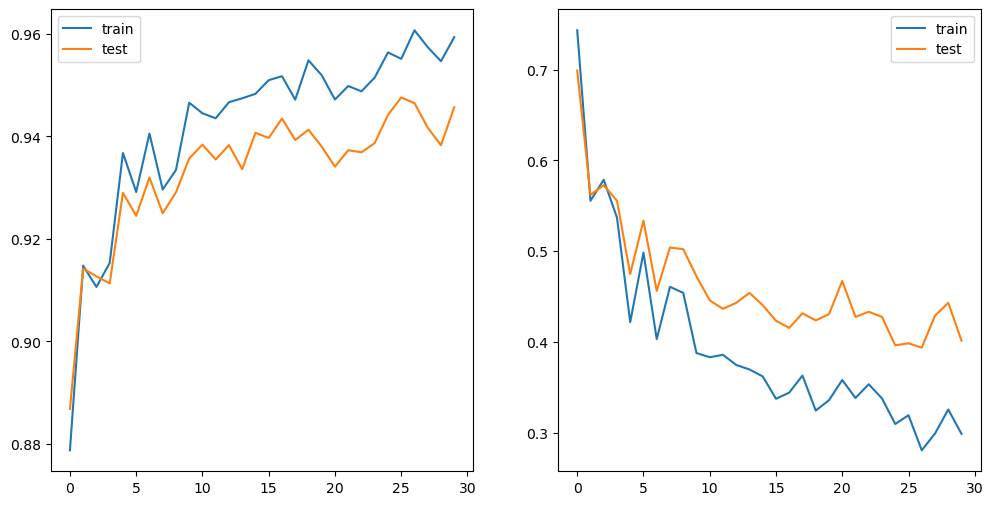

In [14]:
plot_results(results)

In [15]:
NET2 = Network(30, loss=CrossEntropyLoss)
results2 = NET2.SGD(train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9534


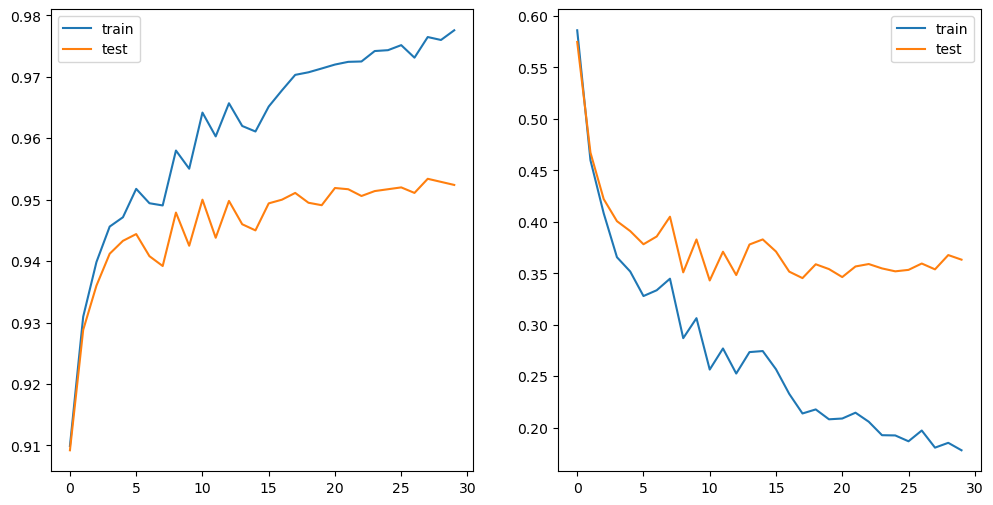

In [16]:
plot_results(results2)

### Added L2 regularization, $\lambda=10^{-4}$

In [17]:
NET3 = Network(30, loss=CrossEntropyLoss)
results3 = NET3.SGD(train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9628


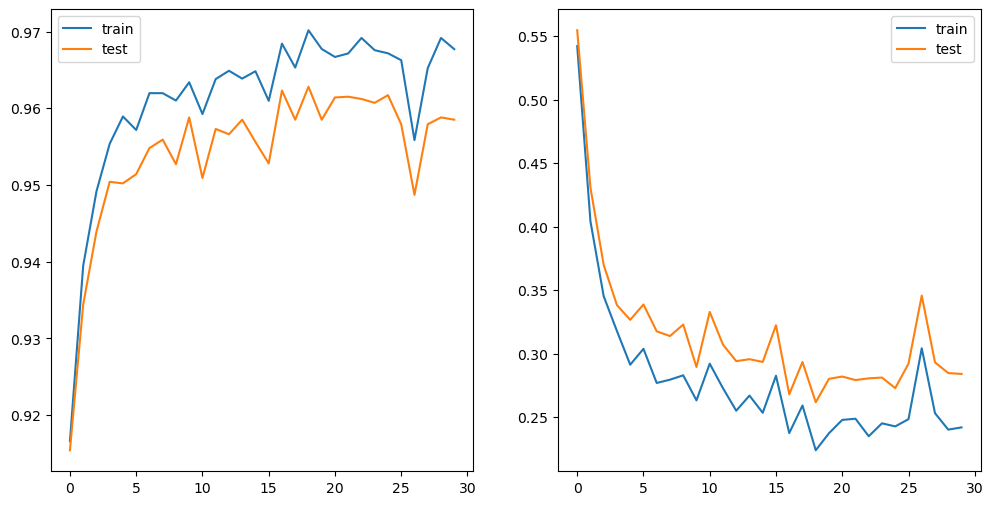

In [18]:
plot_results(results3)

### Added normalized initialization

In [19]:
NET4 = Network(30, loss=CrossEntropyLoss, init='normalized')
results4 = NET4.SGD(train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9611


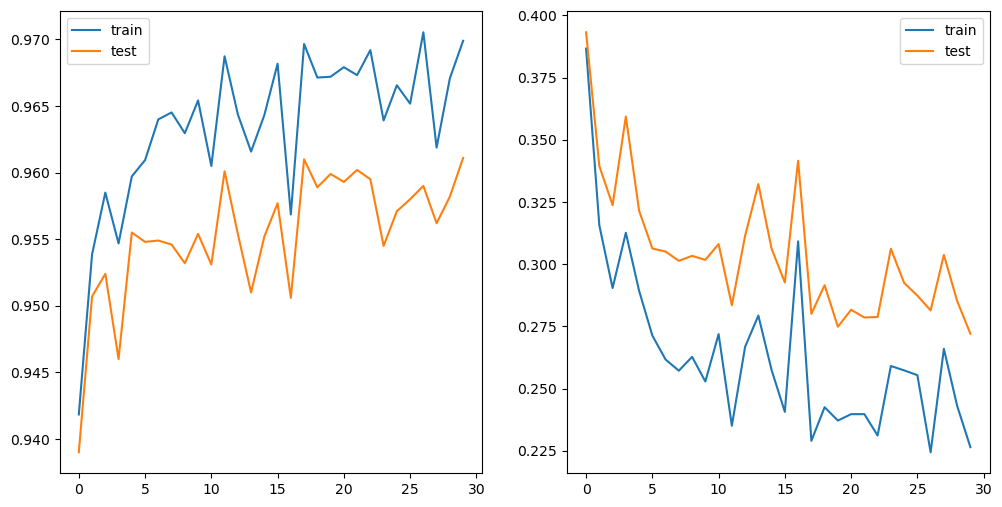

In [20]:
plot_results(results4)

### As first modification, we add the Early stopping with thresholds thre= $10^{-1}$

In [21]:
NET_7 = Network(30, loss=CrossEntropyLoss, init='normalized')
results_7 = NET_7.SGD_with_early(train_data, 
                    thre= 1e-1, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)  

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9543


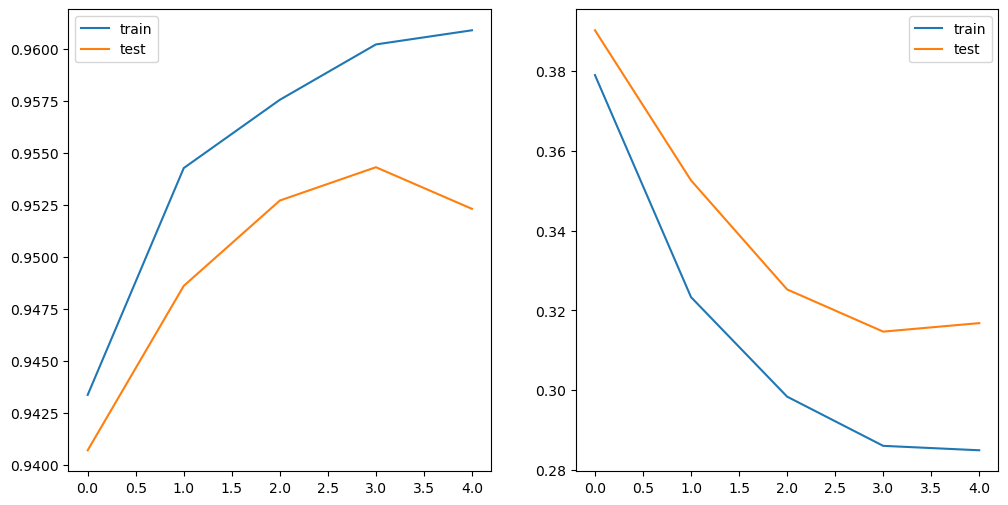

In [22]:
plot_results(results_7)

### As For other, we try with thresholds thre= $6\times 10^{-2}$

In [23]:
NET_8 = Network(30, loss=CrossEntropyLoss, init='normalized')
results_8 = NET_8.SGD_with_early(train_data, 
                    thre= 6e-2, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data) 

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9551


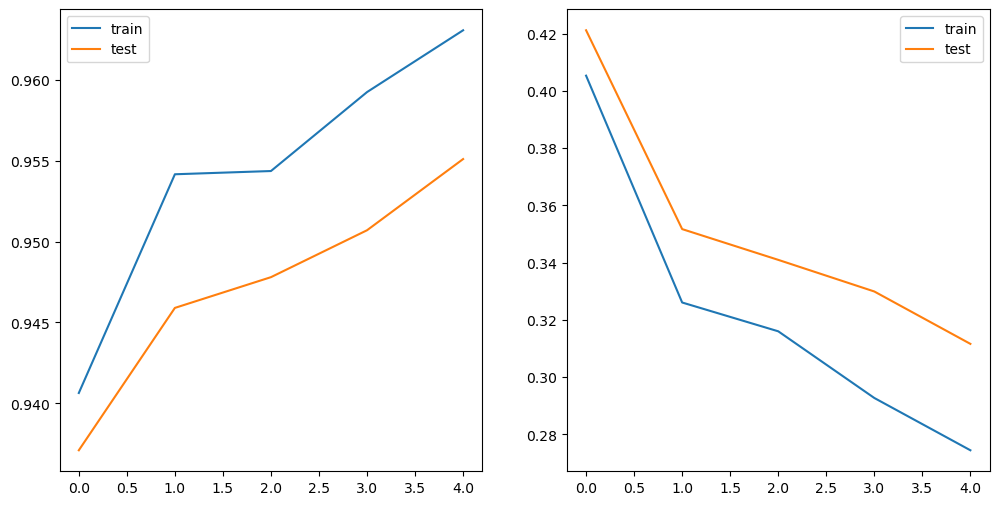

In [24]:
plot_results(results_8)

# Comment:

small improvement on accuracy


###  data augmentation

In [29]:
def plot_digit(img):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    plt.imshow(1-img, cmap='gray')

In [30]:
def shifted_image(img, shift_r, shift_c):
    img = np.reshape(img, (IMG_LEN, IMG_LEN))
    res = np.zeros_like(img)
    for row in range(IMG_LEN):
        new_row = row + shift_r
        if new_row >= 0 and new_row < IMG_LEN:
            for col in range(IMG_LEN):
                new_col = col + shift_c
                if new_col >= 0 and new_col < IMG_LEN:
                    res[new_row, new_col] = img[row, col]
    return np.reshape(res, (IMG_SIZE,))

In [31]:
expanded_train_data = []
for x, ylabel in train_data:
    expanded_train_data.append((x, ylabel))
    for r_shift, c_shift in [(+1, 0), (-1, 0), (0, +1), (0, -1)]:
        expanded_train_data.append((
            shifted_image(x, r_shift, c_shift),
            ylabel
        ))

###  run on expanded data set

In [32]:
NET5 = Network(30, loss=CrossEntropyLoss, init='normalized')
results5 = NET5.SGD(expanded_train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9678


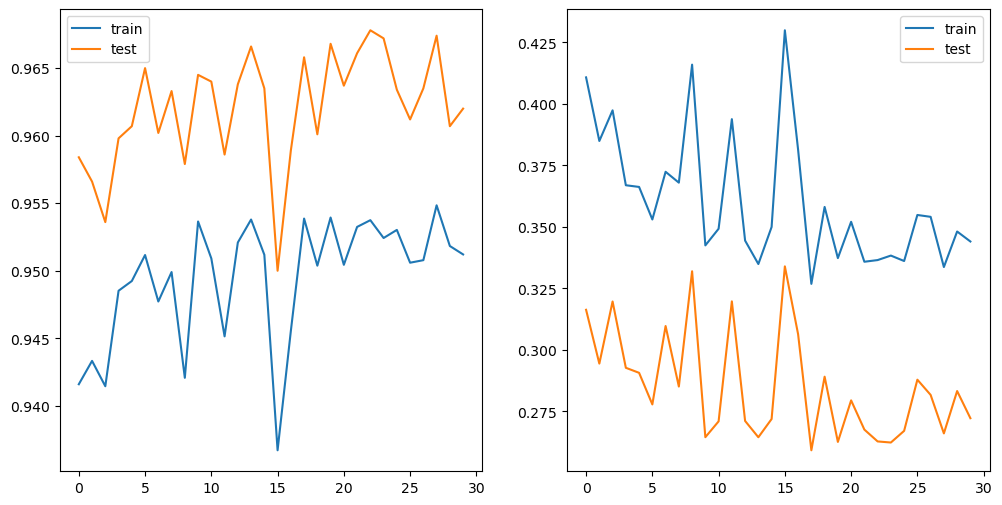

In [33]:
plot_results(results5)  

### As  modification, we add the Early stopping with thresholds thre= $10^{-1} $ but on the expanded data set

In [34]:
NET_12 = Network(30, loss=CrossEntropyLoss, init='normalized')
results_12 = NET_12.SGD_with_early(expanded_train_data, 
                    thre= 1e-1, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)  

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9634


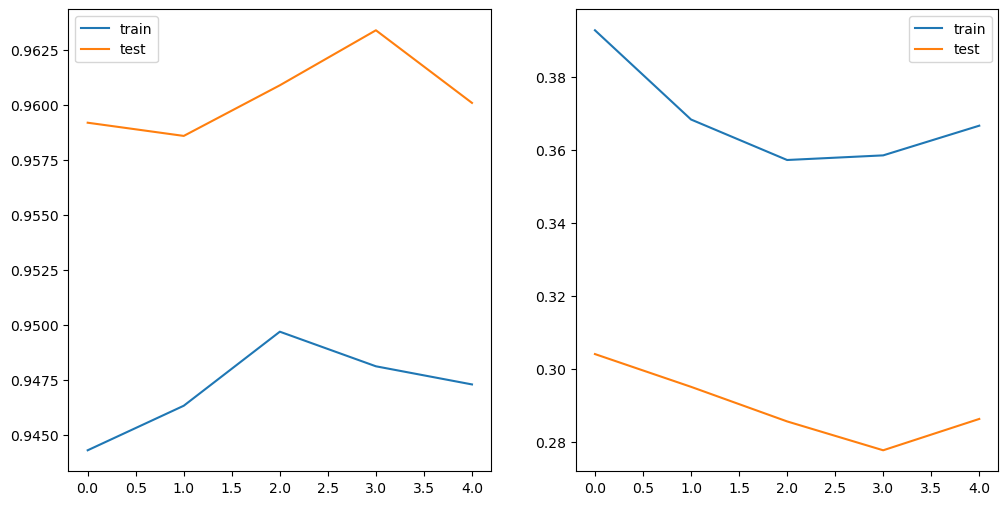

In [35]:
plot_results(results_12)

# Comment:
The test accuracy is somehow  far than the training accuracy for the both.  But with the early stopping it is farther than without early stopping

# Variable learning rate:
### We wait until the network does not improve according to the early stopping rule. Then divide the learning rate by 10. Repeat that three times.

# Let's do modification on variable learning rate by trying  $thre= 3\times 10^{-2}$

In [36]:
NET_9 = Network(30, loss=CrossEntropyLoss, init='normalized')
results_9 = NET_9.SGD_with_var_eta(train_data, 
                                      thre= 3e-2, 
                                      mini_batch_size=10, 
                                      eta=0.5, 
                                      lmbda=10**(-4),
                                      test_data=test_data)



Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9637


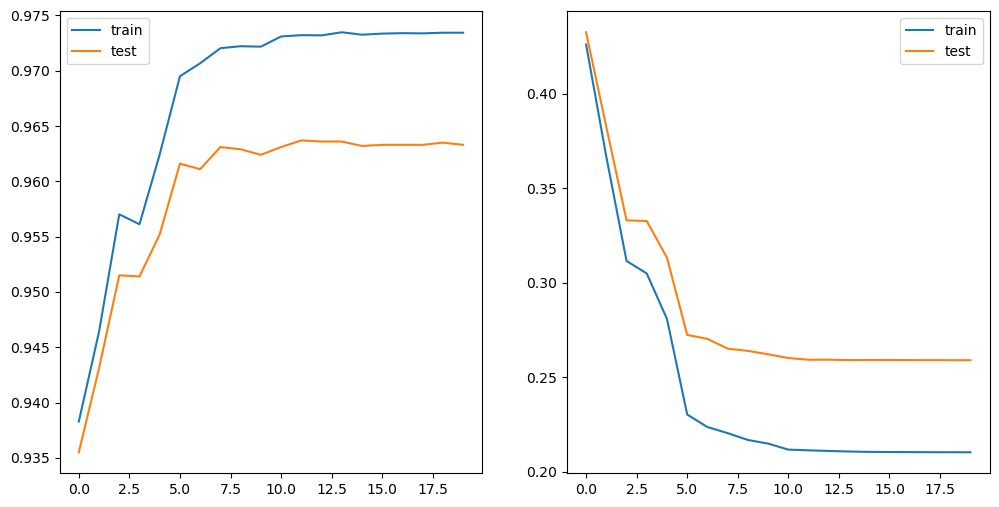

In [37]:
plot_results(results_9)

#  Comment: 
On the training data, we can see that there is a improvement on test error and training error compare to the  plot without variable learning, Morover the accuracy become constant at some point for test error and training error. We can also note some small overfitting at some points. Also with variable learning rate, our model  converge faster and the accuracy is improved (may be because the learning rate is adjusted to be larger when the gradient is small and smaller when the gradient is large).

#  Let's do  modification on variable learning rate by trying  $thre= 3\times  10^{-2}$   on expanded data set

In [38]:
NET_12 = Network(30, loss=CrossEntropyLoss, init='normalized')
results_12 = NET_12.SGD_with_var_eta(expanded_train_data, 
                    thre= 3e-2, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data) 

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9622


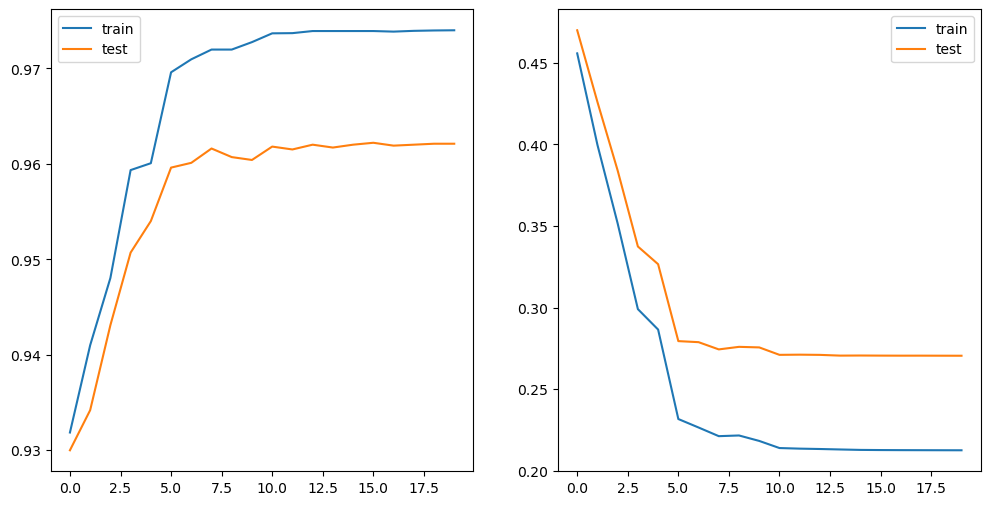

In [39]:
plot_results(results_12)

# Comment:

Compare to the train data, we can see that there is not improvement on accuracy with variable learning rate on on expanded data set.

###  Let's try 100 neurons

In [40]:
NET5 = Network(100, loss=CrossEntropyLoss, init='normalized')
results_5 = NET5.SGD(expanded_train_data, 
                    epochs=30, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data)




Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished


0.9814


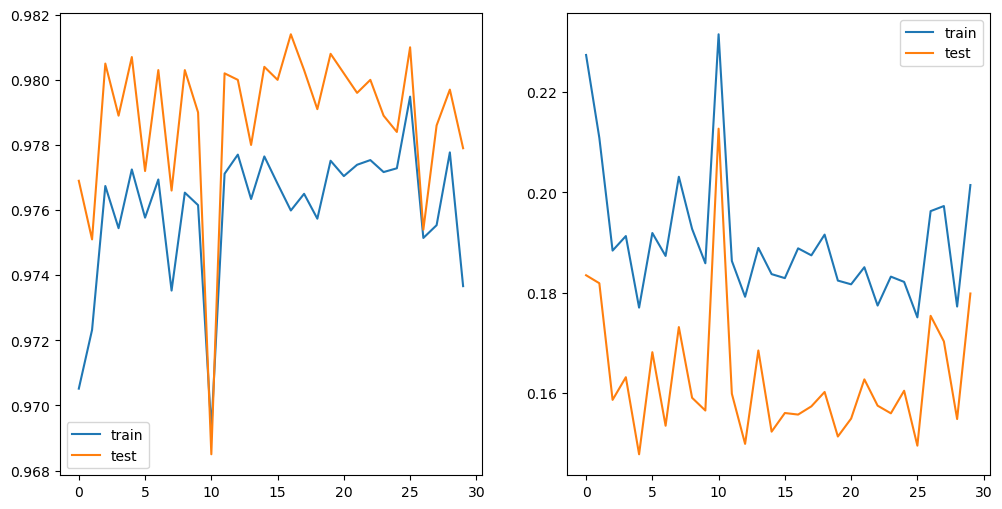

In [41]:
plot_results(results_5)

# Comment:

With 100 neurons, the accuracy become really big (almost 98.14%). So our model is sensitive to the nombers of neurones. 

# For the other modification, we make another Early stopping with thresholds thre= $10^{-1}$ but with 100 neurons

In [42]:
NET_10 = Network(100, loss=CrossEntropyLoss, init='normalized')
results10 = NET_10.SGD_with_early(expanded_train_data, 
                    thre= 1e-1, 
                    mini_batch_size=10, 
                    eta=0.5, 
                    lmbda=10**(-4),
                    test_data=test_data) 

Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9801


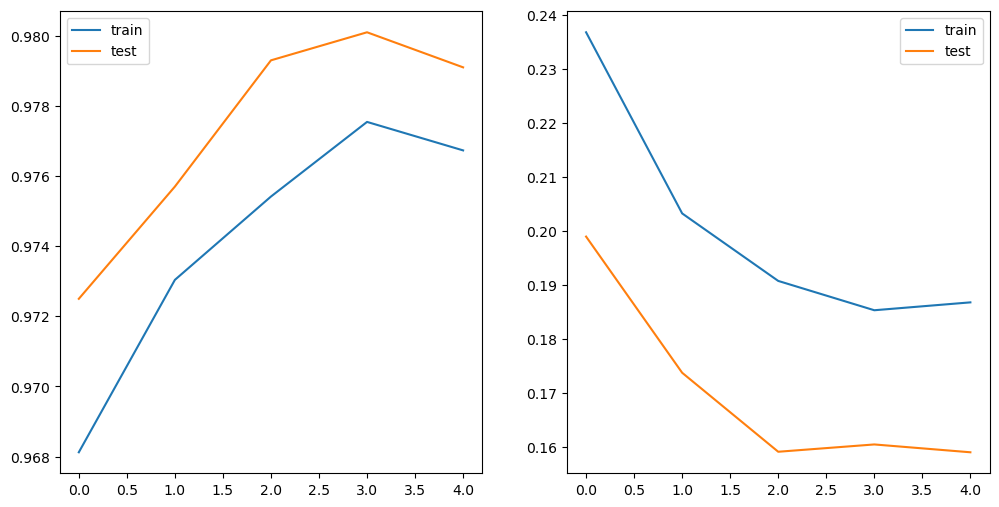

In [43]:
plot_results(results10)

# Comment:

With 100 neurons, when we add the Early stopping, we can see that  the accuracy decrease comprare to the one without  Early stopping. Maybe this is because the model have reached its maximum accuracy with 100 neurons without the Early stopping, the accuracy without the Early stopping is in our case 98.14 %   

# For the other modification, we make another Variable learning rate with thresholds thre= $6\times 10^{-2}$ but with 100 neurons

In [44]:
NET_11 = Network(100, loss=CrossEntropyLoss, init='normalized')
results_11 = NET_11.SGD_with_var_eta(expanded_train_data, 
                                      thre= 6e-2, 
                                      mini_batch_size=10, 
                                      eta=0.5, 
                                      lmbda=10**(-4),
                                      test_data=test_data)



Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 0 finished
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished


0.9779


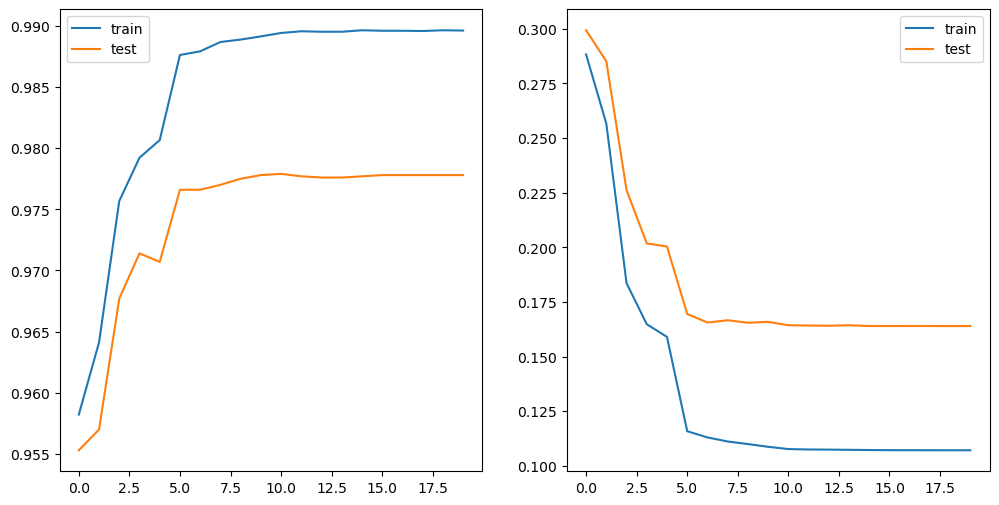

In [45]:
plot_results(results_11)

# Comment:

As for previous case With 100 neurons and without the Early stopping, when we add the variable learning, we can see that  the accuracy decrease comprare to the one without  the variable learning. Maybe this is because the model have reached its maximum accuracy with 100 neurons without  the variable learning. Let us remember that the accuracy without the the variable learning is in our case 98.14 %. 

# Problem 5: Fashion MNIST




Epoch 1/15


750/750 [==============================] - 35s 45ms/step - loss: 0.5439 - accuracy: 0.8000 - val_loss: 0.3759 - val_accuracy: 0.8645
Epoch 2/15
750/750 [==============================] - 35s 47ms/step - loss: 0.3499 - accuracy: 0.8705 - val_loss: 0.3203 - val_accuracy: 0.8807
Epoch 3/15
750/750 [==============================] - 37s 49ms/step - loss: 0.2985 - accuracy: 0.8885 - val_loss: 0.2872 - val_accuracy: 0.8980
Epoch 4/15
750/750 [==============================] - 36s 48ms/step - loss: 0.2684 - accuracy: 0.9012 - val_loss: 0.3008 - val_accuracy: 0.8865
Epoch 5/15
750/750 [==============================] - 36s 48ms/step - loss: 0.2428 - accuracy: 0.9100 - val_loss: 0.2613 - val_accuracy: 0.9056
Epoch 6/15
750/750 [==============================] - 37s 50ms/step - loss: 0.2221 - accuracy: 0.9175 - val_loss: 0.2609 - val_accuracy: 0.9061
Epoch 7/15
750/750 [==============================] - 37s 49ms/step - loss: 0.2054 - accuracy: 0.9234 - val_loss: 0.2569 - val_accu

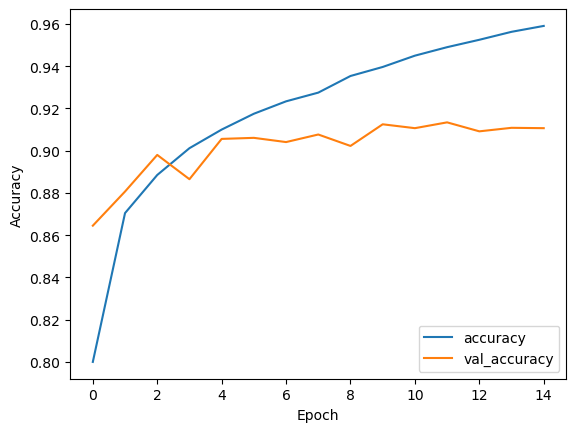

In [62]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Step 2: Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Step 3: Preprocess the data
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255

# Step 4: Build a convolutional neural network model
def create_model(optimizer='adam', dropout_rate=0.2):
    model = models.Sequential([
        layers.Conv2D(64, (2, 2), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')])
    return model

# Create the model
model = create_model()

# Step 5: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(train_images, train_labels, epochs=15, batch_size=64, validation_split=0.2)

# Step 7: Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
